In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)
df.head(2)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0


In [3]:
df.shape, df.isnull().sum(), df.nunique()

((26709, 3),
 article_link    0
 headline        0
 is_sarcastic    0
 dtype: int64,
 article_link    26708
 headline        26602
 is_sarcastic        2
 dtype: int64)

In [4]:
df.drop('article_link', axis=1, inplace=True)

In [5]:
df = df.drop_duplicates(subset=['headline'])
df.reset_index(drop=True, inplace=True)

In [6]:
df['headline_length']=df['headline'].apply(len)

In [17]:
df['headline_length'].mean()

60.977595669498534

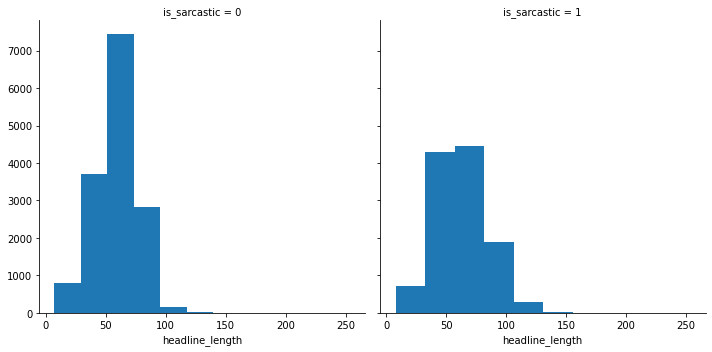

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g = sns.FacetGrid(df,col='is_sarcastic',size=5)
g.map(plt.hist,'headline_length')

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
sequence_length = 60

In [16]:
max_features = 20000 #no. of words

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(df['headline'].values)

X = tokenizer.texts_to_sequences(df['headline'].values)

X = pad_sequences(X, sequence_length)

y = pd.get_dummies(df['is_sarcastic']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print("test set size " + str(len(X_test)))

test set size 2661


In [19]:
import os

embeddings_index = {}
f = open(os.path.join('glove_embedding/', 'glove.6B.100d.txt')) # glove embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 36611 unique tokens.


In [22]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

20001


In [28]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import *

model = Sequential()
model.add(Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=sequence_length,
                    trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(units=2, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 52, 100)           2000100   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 52, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 52, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

In [30]:
batch_size = 32
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=1, validation_split=0.2)

Epoch 1/5
599/599 [==============================] - 39s 65ms/step - loss: 0.4593 - accuracy: 0.7833 - val_loss: 0.3418 - val_accuracy: 0.8490
Epoch 2/5
599/599 [==============================] - 41s 69ms/step - loss: 0.3066 - accuracy: 0.8714 - val_loss: 0.3283 - val_accuracy: 0.8490
Epoch 3/5
599/599 [==============================] - 42s 70ms/step - loss: 0.2215 - accuracy: 0.9115 - val_loss: 0.2869 - val_accuracy: 0.8760
Epoch 4/5
599/599 [==============================] - 42s 70ms/step - loss: 0.1629 - accuracy: 0.9384 - val_loss: 0.2984 - val_accuracy: 0.8764
Epoch 5/5
599/599 [==============================] - 42s 70ms/step - loss: 0.1165 - accuracy: 0.9583 - val_loss: 0.3546 - val_accuracy: 0.8739
